- Instalar tudo que está aqui: https://github.com/Unity-Technologies/ml-agents/blob/main/docs/Getting-Started.md
- Instalar Unity Gim - pip3 install gym_unity
 

In [1]:
from mlagents_envs.environment import UnityEnvironment
from gym_unity.envs import UnityToGymWrapper

In [11]:
import evolvepy as ep
import numpy as np
from matplotlib import pyplot as plt
import unity_utils as uutils

In [3]:
args = {"path": "D:\\Github\\ml-agents\\builds\\3dball_single\\UnityEnvironment.exe"}
evaluator = ep.evaluator.ProcessEvaluator(uutils.Unity3DBallEvaluator, args = args)

#multiple_evaluation = ep.evaluator.MultipleEvaluation(evaluator, 10, discard_max=True, discard_min=True)

In [19]:
sizes = [20, 20,  2] # Units of each layer
input_size = 8 # Network input size (= observation size)

names = []
chr_sizes = []
types = []
ranges = []

for i in range(len(sizes)):
    total_weights = input_size*sizes[i]

    names.append("layer"+str(i)+"w")
    names.append("layer"+str(i)+"b")

    chr_sizes.append(total_weights)
    chr_sizes.append(sizes[i])

    ranges.append((-1.0, 1.0))
    ranges.append((-1.0, 1.0))

    types.append(np.float32)
    types.append(np.float32)

    input_size = sizes[i]

descriptor = ep.generator.Descriptor(chr_sizes, ranges, types, names)

In [5]:
import multiprocessing as mp

population_size = (100//mp.cpu_count())*mp.cpu_count()
population_size

96

In [6]:
first = ep.generator.Layer()
sort = ep.generator.Sort()

first.next = sort

concat = ep.generator.Concatenate()

predation = ep.generator.RandomPredation(int(0.75*population_size))
combine = ep.generator.CombineLayer(ep.generator.selection.tournament, ep.generator.crossover.one_point)
mutation = ep.generator.mutation.NumericMutationLayer(ep.generator.mutation.sum_mutation, 1.0, 0.9, (-0.5, 0.5))
filter0 = ep.generator.FilterFirsts(int(np.floor(0.95*population_size)))

sort.next = predation
predation.next = combine
combine.next = mutation
mutation.next = filter0
filter0.next = concat

filter1 = ep.generator.FilterFirsts(int(np.ceil(0.05*population_size)))

sort.next = filter1
filter1.next = concat

generator = ep.generator.Generator(first_layer=first, last_layer=concat, descriptor=descriptor)


In [7]:
from evolvepy.integrations.wandb import WandbLogger

dyn_mut = ep.callbacks.DynamicMutation([mutation.name], refinement_patience=5, exploration_patience=5, refinement_steps=5)
logger = WandbLogger("3DBall2", "EvolvePy Example")

evolver = ep.Evolver(generator, evaluator, population_size, [dyn_mut, logger])

In [8]:
hist, last_pop = evolver.evolve(70)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: eltoncn (use `wandb login --relogin` to force relogin)


In [1]:
import wandb

In [3]:
api = wandb.Api()

In [4]:
runs = api.runs("eltoncn" + "/" + "EvolvePy Example") 


In [13]:
df = runs[0].history()

In [32]:
hist = np.array(df["best_fitness"][:70])
hist = hist.reshape(70, -1)

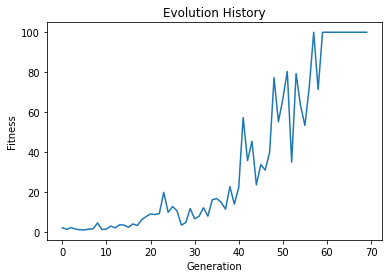

In [73]:
plt.plot(hist.max(axis=1))
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Evolution History")
plt.show()

In [3]:
import tensorflow.python.keras.applications

In [4]:
from tensorflow.python import keras

In [5]:
keras.applications

<module 'tensorflow.python.keras.applications' from 'C:\\Python38\\lib\\site-packages\\tensorflow\\python\\keras\\applications\\__init__.py'>

In [13]:
import tf2onnx
from evolvepy.integrations.tf_keras import transfer_weights
from tensorflow import keras
import tensorflow as tf

In [15]:
model = keras.Sequential([keras.layers.Dense(20, activation="relu", input_shape=(8,)),
                            keras.layers.Dense(20, activation="relu"),
                            keras.layers.Dense(2, activation="sigmoid"),
                            keras.layers.Dense(2, activation="linear")])

In [ ]:
best = last_pop[np.argmax(hist[-1])]

In [17]:
best_data = np.load("D:\\Github\\evolvepy\\examples\\wandb\\run-20220109_194643-2xuoq82x\\files\\best_individual71.npy", allow_pickle=True).item()

In [20]:
best_original = np.empty(1, descriptor.dtype)

for name in best_data:
    names = name.split("/")
    best_original[0][names[1]][int(names[2])] = best_data[name]

In [60]:
fields = descriptor.dtype.fields
fields2 = {}
index = 0
for name in fields:
    fields2["weights"+str(index)] = fields[name]
    index += 1

dtype = np.dtype(fields2)

In [30]:
from mlagents_envs.environment import UnityEnvironment
from gym_unity.envs import UnityToGymWrapper


unity_env = UnityEnvironment()
env = UnityToGymWrapper(unity_env, allow_multiple_obs=True)

[INFO] Listening on port 5004. Start training by pressing the Play button in the Unity Editor.
[INFO] Connected to Unity environment with package version 2.1.0-exp.1 and communication version 1.5.0
[INFO] Connected new brain: 3DBall?team=0


C:\Python38\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [31]:
test_evaluator  = uutils.Unity3DBallEvaluator(show=True, args = args, env=env)

In [32]:
test_evaluator.evaluate(best_original)
env.close()